In [ ]:
pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
TICKER = yf.Ticker("SPY")
TICKER_DF = TICKER.history(start="2013-01-01",end="2023-01-01")
TICKER_DF_SUB = TICKER_DF[['Open','Close']]

TICKER_DF_SUB.head()

,Open,Close
Date,,
2013-01-02 00:00:00-05:00,119.196186,119.976532
2013-01-03 00:00:00-05:00,119.918968,119.705391
2013-01-04 00:00:00-05:00,119.902593,120.231155
2013-01-07 00:00:00-05:00,119.803991,119.902557
2013-01-08 00:00:00-05:00,119.688994,119.557564


In [4]:
TICKER_DF_SUB["Slow"] = TICKER_DF_SUB['Close'].rolling(window = 200).mean()
TICKER_DF_SUB["Fast"] = TICKER_DF_SUB['Close'].rolling(window = 50).mean()
TICKER_DF_SUB = TICKER_DF_SUB.dropna()
TICKER_DF_SUB.head()

<ipython-input-4-0dad89467a3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TICKER_DF_SUB["Slow"] = TICKER_DF_SUB['Close'].rolling(window = 200).mean()
<ipython-input-4-0dad89467a3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TICKER_DF_SUB["Fast"] = TICKER_DF_SUB['Close'].rolling(window = 50).mean()


,Open,Close,Slow,Fast
Date,,,,
2013-10-16 00:00:00-04:00,142.291925,143.417130,132.841249,139.632365
2013-10-17 00:00:00-04:00,142.833710,144.375656,132.963244,139.713391
2013-10-18 00:00:00-04:00,144.909071,145.350815,133.091471,139.803633
2013-10-21 00:00:00-04:00,145.400777,145.359100,133.217111,139.902170
2013-10-22 00:00:00-04:00,145.784218,146.200958,133.348603,140.020863


In [5]:
SIGNAL = []
Fast = TICKER_DF_SUB['Fast']
Slow = TICKER_DF_SUB['Slow']


for i in range(len(TICKER_DF_SUB)):
  if i == 0:
    SIGNAL.append("NO_SIGNAL")
  else:
    prev_fast = Fast[i-2]
    prev_slow = Slow[i-2]
    cur_fast = Fast[i-1]
    cur_slow = Slow[i-1]
    if ((prev_fast < prev_slow) & (cur_fast > cur_slow)):
      SIGNAL.append("BUY")
    elif ((prev_fast > prev_slow) & (cur_fast < cur_slow)):
      SIGNAL.append("SELL")
    else:
      SIGNAL.append("NO_SIGNAL")

TICKER_DF_SUB['SIGNAL'] = SIGNAL

In [6]:
buy_indexes = list(TICKER_DF_SUB[TICKER_DF_SUB['SIGNAL'] == 'BUY'].index)
sell_indexes = list(TICKER_DF_SUB[TICKER_DF_SUB['SIGNAL'] == 'SELL'].index)

if len(sell_indexes) > len(buy_indexes):
  sell_indexes.pop(0)

BUY_PRICES = [TICKER_DF_SUB[TICKER_DF_SUB.index == buy_indexes[i]].Open[0] for i in range(len(buy_indexes))]
SELL_PRICES = [TICKER_DF_SUB[TICKER_DF_SUB.index == sell_indexes[i]].Open[0] for i in range(len(sell_indexes))]

if len(BUY_PRICES) > len(SELL_PRICES):
  SELL_PRICES.append(TICKER_DF_SUB.iloc[len(df)-1,:].Open)
  sell_indexes.append(TICKER_DF_SUB.iloc[len(df)-1,:].name)

returns = list(np.array(SELL_PRICES) / np.array(BUY_PRICES) -1)

BACKTEST_DF = pd.DataFrame({
    "BUY_DATES":buy_indexes,
    "SELL_DATES":sell_indexes,
    "BUY_PRICES":BUY_PRICES,
    "SELL_PRICES":SELL_PRICES,
    "RETURN":returns
})

In [7]:
r = 1
for i in BACKTEST_DF.RETURN:
  r = r * (1+i)

total_return = r / 1 - 1
print("The total return is: " + '{:.1%}'.format(total_return))

The total return is: 82.3%


In [8]:
## Adds a signal column to our data given a slow and fast moving average
def add_sma(df,slow,fast):
  slow_sma = df['Close'].rolling(window = slow).mean()
  df["Slow"] = slow_sma
  fast_sma = df['Close'].rolling(window = fast).mean()
  df["Fast"] = fast_sma
  Slow = df['Slow']
  Fast = df['Fast']
  SIGNAL = []
  for i in range(len(df)):
    if i == 0:
      SIGNAL.append("NO_SIGNAL")
    else:
      prev_fast = Fast[i-2]
      prev_slow = Slow[i-2]
      cur_fast = Fast[i-1]
      cur_slow = Slow[i-1]
      if ((prev_fast < prev_slow) & (cur_fast > cur_slow)):
        SIGNAL.append("BUY")
      elif ((prev_fast > prev_slow) & (cur_fast < cur_slow)):
        SIGNAL.append("SELL")
      else:
        SIGNAL.append("NO_SIGNAL")
  df['SIGNAL'] = SIGNAL

## Runs a backtest on our data (signal column is required)
def backtest(df):

  buy_indexes = list(df[df['SIGNAL'] == 'BUY'].index)
  sell_indexes = list(df[df['SIGNAL'] == 'SELL'].index)

  if len(sell_indexes) > len(buy_indexes):
    sell_indexes.pop(0)

  BUY_PRICES = [df[df.index == buy_indexes[i]].Open[0] for i in range(len(buy_indexes))]
  SELL_PRICES = [df[df.index == sell_indexes[i]].Open[0] for i in range(len(sell_indexes))]

  if len(BUY_PRICES) > len(SELL_PRICES):
    SELL_PRICES.append(df.iloc[len(df)-1,:].Open)
    sell_indexes.append(df.iloc[len(df)-1,:].name)

  returns = list(np.array(SELL_PRICES) / np.array(BUY_PRICES) -1)

  BACKTEST_DF = pd.DataFrame({
      "BUY_DATES":buy_indexes,
      "SELL_DATES":sell_indexes,
      "BUY_PRICES":BUY_PRICES,
      "SELL_PRICES":SELL_PRICES,
      "RETURN":returns
  })

  return BACKTEST_DF

## Calculates our total return from our backtest data frame
def CUMU_RETURNS(df):
  r = 1
  for i in df.RETURN:
    r = r * (1+i)
  return (r / 1) - 1

## Tries every combination of moving
def MA_OPTIMIZER(df,fast,slow):
  FAST = []
  SLOW = []
  RETURN = []
  for f in fast:
    for s in slow:
      FAST.append(f)
      SLOW.append(s)
      BACKTEST_DF = df

      add_sma(BACKTEST_DF,s,f)
      RETURN.append(CUMU_RETURNS(backtest(BACKTEST_DF)))

  results = pd.DataFrame({
      "FAST":FAST,
      "SLOW":SLOW,
      "RETURNS":RETURN
  })
  return results

In [9]:
TICKER = yf.Ticker("SPY")
TICKER_DF = TICKER.history(start="2013-01-01",end="2023-01-01")
TICKER_DF_SUB = TICKER_DF[['Open','Close']]

results = MA_OPTIMIZER(TICKER_DF_SUB,fast = range(10,100,5),slow = range(105,300,5))
results.sort_values(by=['RETURNS']).tail(1)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Slow"] = slow_sma
<ipython-input-8-4acd21a84b16>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fast"] = fast_sma
<ipython-input-8-4acd21a84b16>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SIGNAL'] = SIGNAL
<ipython-input-8-4acd21a84b16>:4: SettingWithCopyWarning: 
A value is trying to be set on a c

,FAST,SLOW,RETURNS
627,90,120,0.974246


<ipython-input-8-4acd21a84b16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Slow"] = slow_sma
<ipython-input-8-4acd21a84b16>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Fast"] = fast_sma
<ipython-input-8-4acd21a84b16>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

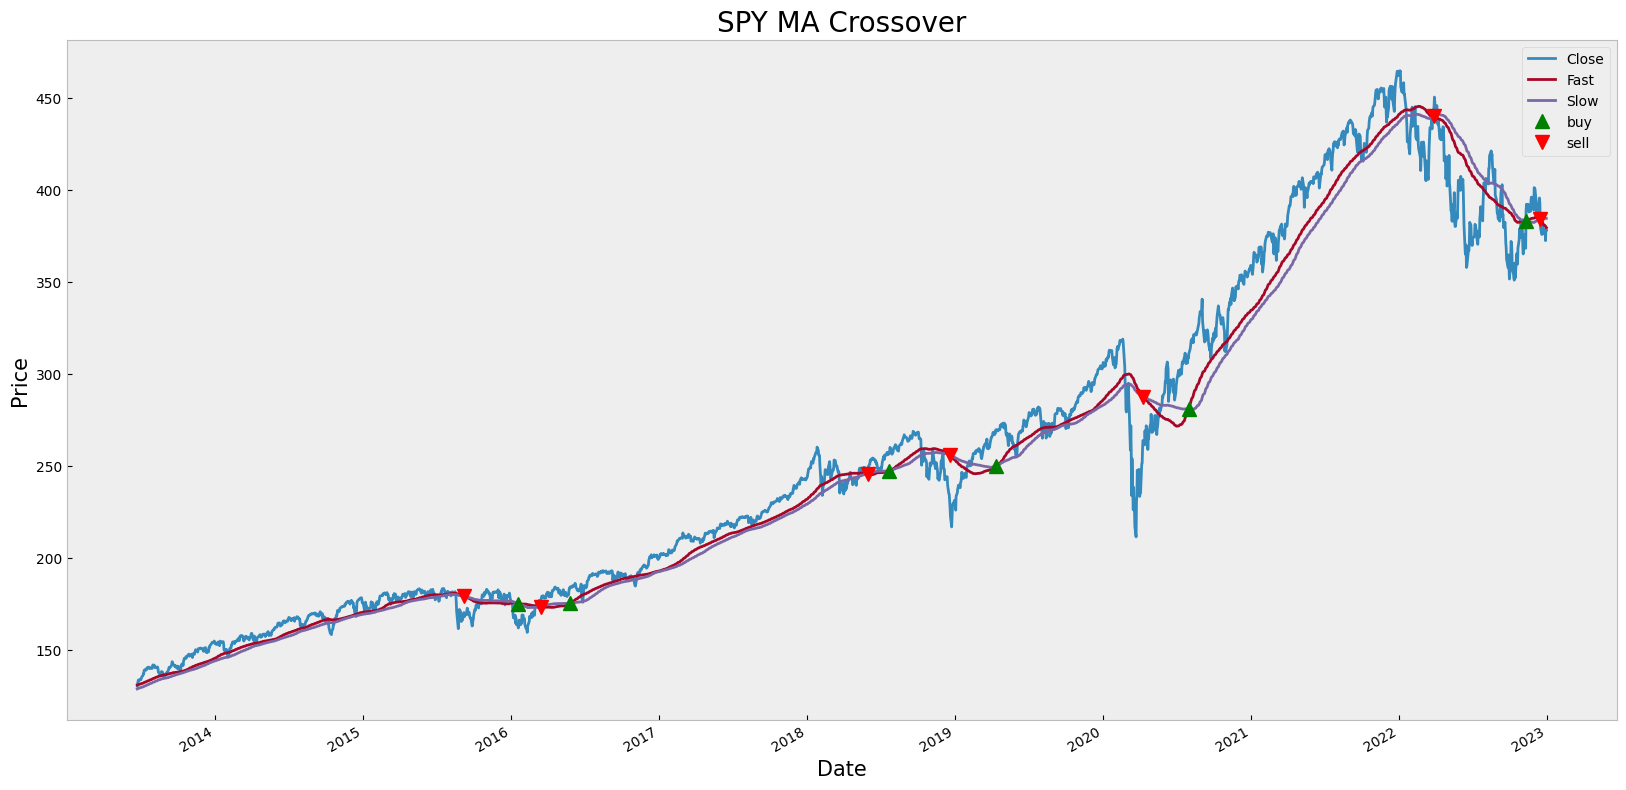

In [10]:
TICKER = yf.Ticker("SPY")
TICKER_DF = TICKER.history(start="2013-01-01",end="2023-01-01")
TICKER_DF_SUB = TICKER_DF[['Open','Close']]

add_sma(
    TICKER_DF_SUB,
    slow = results.sort_values(['RETURNS']).tail(1)['SLOW'].values[0],
    fast = results.sort_values(['RETURNS']).tail(1)['FAST'].values[0])

BACKTEST_DF = backtest(TICKER_DF_SUB)
TICKER_DF_SUB_NONA = TICKER_DF_SUB.dropna()

plt.style.use('bmh')
plt.figure(figsize = (20,10))
TICKER_DF_SUB_NONA["Close"].plot(label= "Close")
TICKER_DF_SUB_NONA["Fast"].plot(label = "Fast")
TICKER_DF_SUB_NONA["Slow"].plot(label = "Slow")

plt.plot(
    TICKER_DF_SUB_NONA[TICKER_DF_SUB_NONA['SIGNAL'] == "BUY"].index,
    TICKER_DF_SUB_NONA[TICKER_DF_SUB_NONA['SIGNAL'] == "BUY"]['Slow'].values,
    '^',
    markersize = 10,
    color = 'g',
    label = 'buy'
)

plt.plot(
    TICKER_DF_SUB_NONA[TICKER_DF_SUB_NONA['SIGNAL'] == "SELL"].index,
    TICKER_DF_SUB_NONA[TICKER_DF_SUB_NONA['SIGNAL'] == "SELL"]['Slow'].values,
    'v',
    markersize = 10,
    color = 'r',
    label = 'sell'
)

plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('SPY MA Crossover', fontsize = 20)
plt.legend()
plt.grid()
plt.show()